This notebook allows you to train and run the Cath model based on NN presented here (https://ecs193-final-project.herokuapp.com/). In order to run this code, you will need have the cleaned data downloaded. This data is located here https://drive.google.com/file/d/1Kb0CZlWMFVKCJ3hSZiMY6tLucX7bxq1w/view?usp=sharing

In [0]:
!unzip input.zip

Archive:  input.zip
   creating: data/
  inflating: __MACOSX/._data         
  inflating: data/CleanData.csv      
  inflating: __MACOSX/data/._CleanData.csv  
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  


**READ IN THE FILES**

In [0]:
import pandas as pd
import sklearn
import keras
import numpy as np
import matplotlib.pyplot as plt
import warnings
import cv2
import itertools
from sklearn.model_selection import train_test_split,KFold
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.signal import resample
from collections import Counter
from datetime import datetime
from datetime import date
from sklearn.metrics import confusion_matrix
from collections import Counter
warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


In [0]:
df = pd.read_csv("data/CleanData.csv")

In [0]:
df = df.drop(['Unnamed: 0',"UCDID"],axis = 1)

In [0]:
df["Age"][df["Age"] < 20] += 100 #this is entirely old patients

In [0]:
df.shape

(781, 41)

In [0]:
df.head(10)

,Age,RiskRecentSmoker,ACCHxHypertension,ACCHxHypercholesterol,ACCFamilyHxCAD,RiskPriorMI,ACCCHF,ACCValvularSurgery,ACCPrevCoroIntervention,HeightCM,WeightKG,ACCHxKidneyFailure,ACCCerebroVascDisease,ACCPeripheralVascDisease,ACCHxChronicLungDisease,DiabetesHistory,DiabetesTherapy,StudyStressSPECTMRIResult,StudyStressSPECTMRIIschemia,ProcedureDiagnostic,PCIProcedure,Scheduling_Type,PostDiagRxRecommendation,CoronaryDominance,LeftMainStenosisNA,ProcOutcomesLMStenosis,ProxLADStenosisNA,ProcOutcomesLADStenosis,MidDistLADStenosisNA,ProcOutcomesLADDistStenosis,CircStenosisNA,ProcOutcomesCIRCStenosis,RCAStenosisNA,ProcOutcomesRCAStenosis,RamusStenosisNA,ProxLADGraftStenosisNA,MidDistLADGraftStenosisNA,CircGraftStenosisNA,RCAGraftStenosisNA,RamusGraftStenosisNA,Cath_result
0,64,1,1,1,0,0,0,0,0,175.0,89.0,0,0,0,0,1,1,1,-1,1,0,0,1,2,0,0.000000,0,0.0,0,0.00,0,0.00,0,0.0,1,1,1,1,1,1,0
1,64,1,1,1,1,1,1,0,1,130.0,81.0,0,1,0,0,1,1,2,2,1,0,0,1,2,0,0.111111,0,0.0,0,0.70,0,0.50,0,0.4,1,1,1,1,1,1,1
2,66,1,1,0,0,0,0,0,0,175.0,87.6,0,1,0,0,0,-1,2,2,1,1,2,4,1,0,0.000000,0,0.0,0,0.50,0,0.90,0,0.0,1,1,1,1,1,1,1
3,63,0,1,1,0,0,1,0,0,188.0,71.0,0,0,0,0,0,-1,1,-1,1,0,2,1,2,0,0.000000,0,0.0,0,0.00,0,0.00,0,0.0,1,1,1,1,1,1,0
4,63,0,1,1,0,0,0,0,0,170.0,106.5,0,0,1,0,0,-1,2,2,1,0,0,1,2,0,0.000000,0,0.0,0,0.00,0,0.20,0,0.2,1,1,1,1,1,1,0
5,66,0,0,0,0,0,0,0,1,163.1,66.0,0,0,0,0,0,-1,2,3,1,0,2,1,2,0,0.000000,0,0.3,0,0.99,0,0.40,0,0.0,1,1,1,1,1,1,1
6,81,0,0,0,1,0,1,0,0,183.0,68.9,0,0,1,0,0,-1,2,1,1,0,2,1,2,0,0.000000,0,0.0,0,0.30,0,0.60,0,0.4,1,1,1,1,0,1,0
7,69,0,1,1,0,1,0,0,1,157.0,72.0,1,1,0,0,1,1,2,1,1,1,2,4,1,0,0.000000,0,0.0,0,1.00,0,0.90,0,0.4,0,1,1,1,1,1,1
8,69,0,1,1,0,1,0,0,1,160.0,73.5,1,0,0,0,1,1,2,2,0,1,-1,-1,-1,1,-1.000000,1,-1.0,1,-1.00,0,0.99,1,-1.0,1,0,0,0,0,0,1
9,61,1,1,0,0,0,0,0,0,180.1,75.0,0,0,0,0,0,-1,0,-1,1,0,2,1,2,0,0.555556,0,0.3,0,0.60,0,0.50,0,1.0,1,0,0,0,0,0,1


In [0]:
list(df.columns)

['Age',
 'RiskRecentSmoker',
 'ACCHxHypertension',
 'ACCHxHypercholesterol',
 'ACCFamilyHxCAD',
 'RiskPriorMI',
 'ACCCHF',
 'ACCValvularSurgery',
 'ACCPrevCoroIntervention',
 'HeightCM',
 'WeightKG',
 'ACCHxKidneyFailure',
 'ACCCerebroVascDisease',
 'ACCPeripheralVascDisease',
 'ACCHxChronicLungDisease',
 'DiabetesHistory',
 'DiabetesTherapy',
 'StudyStressSPECTMRIResult',
 'StudyStressSPECTMRIIschemia',
 'ProcedureDiagnostic',
 'PCIProcedure',
 'Scheduling_Type',
 'PostDiagRxRecommendation',
 'CoronaryDominance',
 'LeftMainStenosisNA',
 'ProcOutcomesLMStenosis',
 'ProxLADStenosisNA',
 'ProcOutcomesLADStenosis',
 'MidDistLADStenosisNA',
 'ProcOutcomesLADDistStenosis',
 'CircStenosisNA',
 'ProcOutcomesCIRCStenosis',
 'RCAStenosisNA',
 'ProcOutcomesRCAStenosis',
 'RamusStenosisNA',
 'ProxLADGraftStenosisNA',
 'MidDistLADGraftStenosisNA',
 'CircGraftStenosisNA',
 'RCAGraftStenosisNA',
 'RamusGraftStenosisNA',
 'Cath_result']

In [0]:
df_no_norm = df.copy()

In [0]:
def plot_var(var,col):
  plt.figure()
  plt.title("Frequency plot for the " + str(col))
  plt.xlabel(col)
  plt.ylabel("Frequency distribution")
  plt.hist(var,bins = 50)

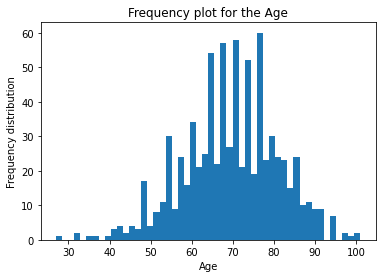

In [0]:
plot_var(df["Age"],"Age")

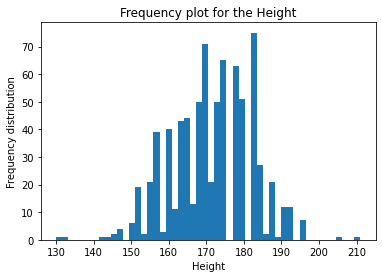

In [0]:
plot_var(df['HeightCM'],"Height")

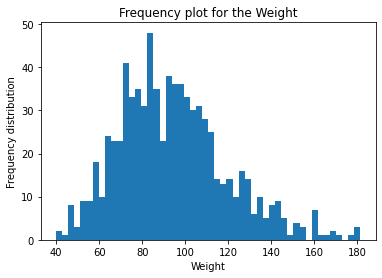

In [0]:
plot_var(df['WeightKG'],"Weight")

**NORMALIZE WEIGHTS AND HEIGHTS AND USE AGE**

In [0]:
scaler1 = sklearn.preprocessing.MinMaxScaler()
scaler2 = sklearn.preprocessing.MinMaxScaler()
scaler3 = sklearn.preprocessing.MinMaxScaler()
df["Age"] = scaler1.fit_transform(np.array(df["Age"]).reshape((-1,1)))
df['HeightCM'] = scaler2.fit_transform(np.array(df["HeightCM"]).reshape((-1,1)))
df['WeightKG'] = scaler3.fit_transform(np.array(df["WeightKG"]).reshape((-1,1)))

In [0]:
import pickle
with open("age_scaler.pkl","wb") as f:
  pickle.dump(scaler1,f)

with open("ht_scaler.pkl","wb") as g:
  pickle.dump(scaler2,g)

with open("wt_scaler.pkl","wb") as h:
  pickle.dump(scaler1,h)

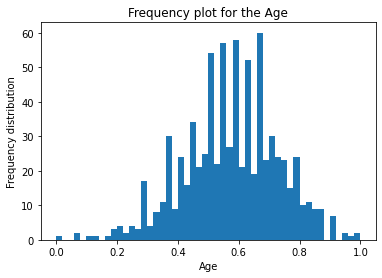

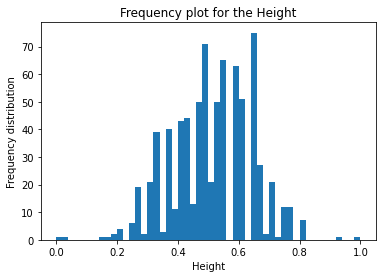

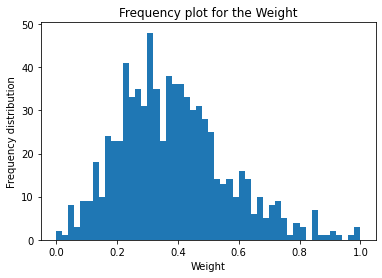

In [0]:
plot_var(df["Age"],"Age")
plot_var(df["HeightCM"],"Height")
plot_var(df["WeightKG"],"Weight")

In [0]:
df.head(10)

,Age,RiskRecentSmoker,ACCHxHypertension,ACCHxHypercholesterol,ACCFamilyHxCAD,RiskPriorMI,ACCCHF,ACCValvularSurgery,ACCPrevCoroIntervention,HeightCM,WeightKG,ACCHxKidneyFailure,ACCCerebroVascDisease,ACCPeripheralVascDisease,ACCHxChronicLungDisease,DiabetesHistory,DiabetesTherapy,StudyStressSPECTMRIResult,StudyStressSPECTMRIIschemia,ProcedureDiagnostic,PCIProcedure,Scheduling_Type,PostDiagRxRecommendation,CoronaryDominance,LeftMainStenosisNA,ProcOutcomesLMStenosis,ProxLADStenosisNA,ProcOutcomesLADStenosis,MidDistLADStenosisNA,ProcOutcomesLADDistStenosis,CircStenosisNA,ProcOutcomesCIRCStenosis,RCAStenosisNA,ProcOutcomesRCAStenosis,RamusStenosisNA,ProxLADGraftStenosisNA,MidDistLADGraftStenosisNA,CircGraftStenosisNA,RCAGraftStenosisNA,RamusGraftStenosisNA,Cath_result
0,0.500000,1,1,1,0,0,0,0,0,0.555556,0.346535,0,0,0,0,1,1,1,-1,1,0,0,1,2,0,0.000000,0,0.0,0,0.00,0,0.00,0,0.0,1,1,1,1,1,1,0
1,0.500000,1,1,1,1,1,1,0,1,0.000000,0.289958,0,1,0,0,1,1,2,2,1,0,0,1,2,0,0.111111,0,0.0,0,0.70,0,0.50,0,0.4,1,1,1,1,1,1,1
2,0.527027,1,1,0,0,0,0,0,0,0.555556,0.336634,0,1,0,0,0,-1,2,2,1,1,2,4,1,0,0.000000,0,0.0,0,0.50,0,0.90,0,0.0,1,1,1,1,1,1,1
3,0.486486,0,1,1,0,0,1,0,0,0.716049,0.219236,0,0,0,0,0,-1,1,-1,1,0,2,1,2,0,0.000000,0,0.0,0,0.00,0,0.00,0,0.0,1,1,1,1,1,1,0
4,0.486486,0,1,1,0,0,0,0,0,0.493827,0.470297,0,0,1,0,0,-1,2,2,1,0,0,1,2,0,0.000000,0,0.0,0,0.00,0,0.20,0,0.2,1,1,1,1,1,1,0
5,0.527027,0,0,0,0,0,0,0,1,0.408642,0.183876,0,0,0,0,0,-1,2,3,1,0,2,1,2,0,0.000000,0,0.3,0,0.99,0,0.40,0,0.0,1,1,1,1,1,1,1
6,0.729730,0,0,0,1,0,1,0,0,0.654321,0.204385,0,0,1,0,0,-1,2,1,1,0,2,1,2,0,0.000000,0,0.0,0,0.30,0,0.60,0,0.4,1,1,1,1,0,1,0
7,0.567568,0,1,1,0,1,0,0,1,0.333333,0.226308,1,1,0,0,1,1,2,1,1,1,2,4,1,0,0.000000,0,0.0,0,1.00,0,0.90,0,0.4,0,1,1,1,1,1,1
8,0.567568,0,1,1,0,1,0,0,1,0.370370,0.236917,1,0,0,0,1,1,2,2,0,1,-1,-1,-1,1,-1.000000,1,-1.0,1,-1.00,0,0.99,1,-1.0,1,0,0,0,0,0,1
9,0.459459,1,1,0,0,0,0,0,0,0.618519,0.247525,0,0,0,0,0,-1,0,-1,1,0,2,1,2,0,0.555556,0,0.3,0,0.60,0,0.50,0,1.0,1,0,0,0,0,0,1


In [0]:
df_no_norm.head(10)

,Age,RiskRecentSmoker,ACCHxHypertension,ACCHxHypercholesterol,ACCFamilyHxCAD,RiskPriorMI,ACCCHF,ACCValvularSurgery,ACCPrevCoroIntervention,HeightCM,WeightKG,ACCHxKidneyFailure,ACCCerebroVascDisease,ACCPeripheralVascDisease,ACCHxChronicLungDisease,DiabetesHistory,DiabetesTherapy,StudyStressSPECTMRIResult,StudyStressSPECTMRIIschemia,ProcedureDiagnostic,PCIProcedure,Scheduling_Type,PostDiagRxRecommendation,CoronaryDominance,LeftMainStenosisNA,ProcOutcomesLMStenosis,ProxLADStenosisNA,ProcOutcomesLADStenosis,MidDistLADStenosisNA,ProcOutcomesLADDistStenosis,CircStenosisNA,ProcOutcomesCIRCStenosis,RCAStenosisNA,ProcOutcomesRCAStenosis,RamusStenosisNA,ProxLADGraftStenosisNA,MidDistLADGraftStenosisNA,CircGraftStenosisNA,RCAGraftStenosisNA,RamusGraftStenosisNA,Cath_result
0,64,1,1,1,0,0,0,0,0,175.0,89.0,0,0,0,0,1,1,1,-1,1,0,0,1,2,0,0.000000,0,0.0,0,0.00,0,0.00,0,0.0,1,1,1,1,1,1,0
1,64,1,1,1,1,1,1,0,1,130.0,81.0,0,1,0,0,1,1,2,2,1,0,0,1,2,0,0.111111,0,0.0,0,0.70,0,0.50,0,0.4,1,1,1,1,1,1,1
2,66,1,1,0,0,0,0,0,0,175.0,87.6,0,1,0,0,0,-1,2,2,1,1,2,4,1,0,0.000000,0,0.0,0,0.50,0,0.90,0,0.0,1,1,1,1,1,1,1
3,63,0,1,1,0,0,1,0,0,188.0,71.0,0,0,0,0,0,-1,1,-1,1,0,2,1,2,0,0.000000,0,0.0,0,0.00,0,0.00,0,0.0,1,1,1,1,1,1,0
4,63,0,1,1,0,0,0,0,0,170.0,106.5,0,0,1,0,0,-1,2,2,1,0,0,1,2,0,0.000000,0,0.0,0,0.00,0,0.20,0,0.2,1,1,1,1,1,1,0
5,66,0,0,0,0,0,0,0,1,163.1,66.0,0,0,0,0,0,-1,2,3,1,0,2,1,2,0,0.000000,0,0.3,0,0.99,0,0.40,0,0.0,1,1,1,1,1,1,1
6,81,0,0,0,1,0,1,0,0,183.0,68.9,0,0,1,0,0,-1,2,1,1,0,2,1,2,0,0.000000,0,0.0,0,0.30,0,0.60,0,0.4,1,1,1,1,0,1,0
7,69,0,1,1,0,1,0,0,1,157.0,72.0,1,1,0,0,1,1,2,1,1,1,2,4,1,0,0.000000,0,0.0,0,1.00,0,0.90,0,0.4,0,1,1,1,1,1,1
8,69,0,1,1,0,1,0,0,1,160.0,73.5,1,0,0,0,1,1,2,2,0,1,-1,-1,-1,1,-1.000000,1,-1.0,1,-1.00,0,0.99,1,-1.0,1,0,0,0,0,0,1
9,61,1,1,0,0,0,0,0,0,180.1,75.0,0,0,0,0,0,-1,0,-1,1,0,2,1,2,0,0.555556,0,0.3,0,0.60,0,0.50,0,1.0,1,0,0,0,0,0,1


**Normalize and Non normalize**

In [0]:
df['Cath_result'].value_counts()

1    480
0    301
Name: Cath_result, dtype: int64

In [0]:
values = df.values
values_no_norm = df_no_norm.values
X_norm,y_norm = values[:,:-1],values[:,-1].astype(int) #remove age
X_no_norm,y_no_norm = values_no_norm[:,:-1],values_no_norm[:,-1].astype(int) #remove age
CHOICE = 300

In [0]:
def split_even(X,y):
  C0 = np.argwhere(y == 0).flatten()
  C1 = np.argwhere(y == 1).flatten()

  subC0 = np.random.choice(C0,CHOICE)
  subC1 = np.random.choice(C1,CHOICE)

  X_final = np.vstack([X[subC0], X[subC1]])
  y_final = np.hstack([y[subC0], y[subC1]])
  return X_final,y_final

In [0]:
X_no_norm = X_no_norm.astype(float)
y_no_norm = y_no_norm.astype(float)

X_norm = X_norm.astype(float)
y_norm = y_norm.astype(float)

In [0]:
X_norm.shape

(781, 40)

In [0]:
y_norm.shape

(781,)

In [0]:
X_no_norm.shape

(781, 40)

In [0]:
y_no_norm.shape

(781,)

In [0]:
X_norm,y_norm = shuffle(X_norm,y_norm,random_state = 42)
X_no_norm,y_no_norm = shuffle(X_no_norm,y_no_norm,random_state = 99)

**BUILD MODELS**

In [0]:
def graph_nn(loss, accuracy, epochs):
    
    plt.figure(1)
    plt.plot(epochs, loss, label='train')
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

    plt.figure(2)
    plt.plot(epochs, accuracy, label='train')
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [0]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [0]:
def ANN(input_dim,num_outputs,num_neurons = 500,activation = "relu",hidden_layers = 3,loss = "binary_crossentropy",optimizer = "Adam"):
    model = None
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(num_neurons,input_dim = input_dim,activation = activation))
    for i in range(hidden_layers):
        model.add(keras.layers.Dense(num_neurons,activation = activation))
    
    model.add(keras.layers.Dense(num_outputs,activation = "sigmoid"))
    print("Let's now compile the model")
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

In [0]:
def KF(X,y,num_splits = 10,epochs = 5,batch_size = 20,normalized = False):
    kf = KFold(n_splits=num_splits, random_state = None)
    foldno = 1
    cross_val_scores = []
    title = str()
    models = []
    if normalized:
      title = 'Confusion matrix with normalization'
    else:
      title = 'Confusion matrix with no normalization'

    for train_index, test_index in kf.split(X):
        print("FOLD NUMBER %d"%foldno)
        
        model = None
        model = ANN(X.shape[1],y.shape[1],num_neurons=300,hidden_layers=3,activation='relu',loss = "binary_crossentropy")
        
        print("TRAIN:", len(train_index), "TEST:", len(test_index))
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        print(Counter(y_train.ravel()),"is the train counts")
        print(Counter(y_test.ravel()),"is the test counts")
        
        history = model.fit(X_train,y_train,batch_size = batch_size,epochs = epochs,verbose = 0)          
        pred = model.predict(X_test)
        scores = model.evaluate(X_test,y_test)
        acc = scores[1] * 100.00
        cross_val_scores.append(acc)
        
        
        print("Test accuracy : %.2f"%acc)
        
        
        foldno += 1
        y_pred = (pred.ravel() > 0.5).astype(int)
        y_test = y_test.ravel().astype(int)
        
        cnf_matrix = confusion_matrix(y_test, y_pred)
        np.set_printoptions(precision=2)
        plot_confusion_matrix(cnf_matrix, classes=["Neg","Pos"],
                      title= title)
        
        loss = history.history['loss']
        accuracy = history.history['accuracy']
        models.append(model)
        graph_nn(loss,accuracy,range(1,epochs + 1))
        print('\n')
    
    max_acc = np.argmax(cross_val_scores)
    best_model = models[max_acc]
    print(f"{max_acc + 1}th is the best model")
    # serialize model to JSON
    model_json = best_model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    best_model.save_weights("model.h5")
    print("Saved model to disk")


    return np.mean(cross_val_scores)

Build with all the features

FOLD NUMBER 1
Let's now compile the model
TRAIN: 702 TEST: 79
Counter({1.0: 433, 0.0: 269}) is the train counts
Counter({1.0: 47, 0.0: 32}) is the test counts
79/79 [==============================] - 0s 346us/step
Test accuracy : 94.94


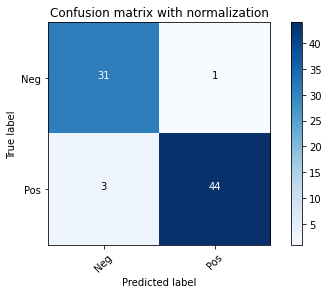

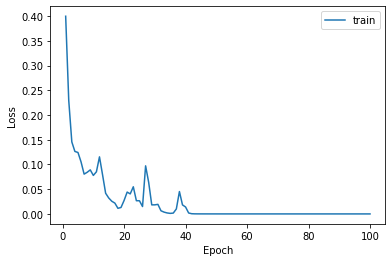

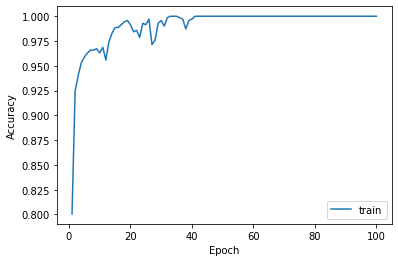



FOLD NUMBER 2
Let's now compile the model
TRAIN: 703 TEST: 78
Counter({1.0: 431, 0.0: 272}) is the train counts
Counter({1.0: 49, 0.0: 29}) is the test counts
78/78 [==============================] - 0s 344us/step
Test accuracy : 97.44


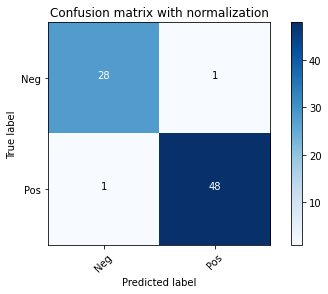

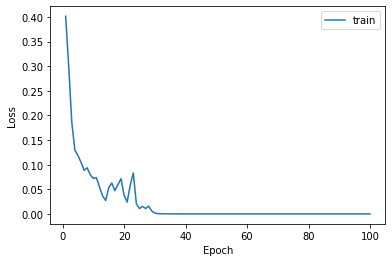

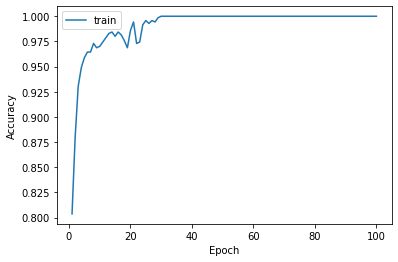



FOLD NUMBER 3
Let's now compile the model
TRAIN: 703 TEST: 78
Counter({1.0: 429, 0.0: 274}) is the train counts
Counter({1.0: 51, 0.0: 27}) is the test counts
78/78 [==============================] - 0s 349us/step
Test accuracy : 89.74


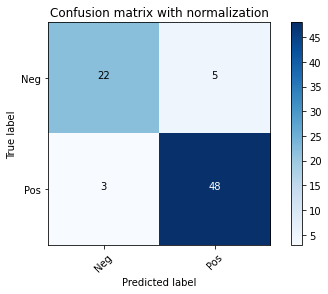

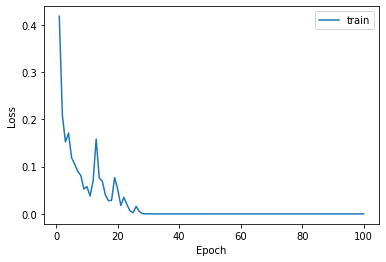

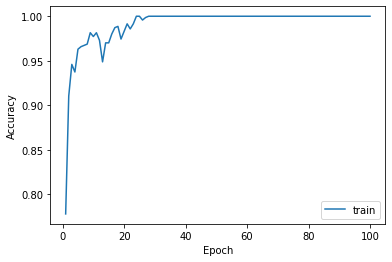



FOLD NUMBER 4
Let's now compile the model
TRAIN: 703 TEST: 78
Counter({1.0: 436, 0.0: 267}) is the train counts
Counter({1.0: 44, 0.0: 34}) is the test counts
78/78 [==============================] - 0s 306us/step
Test accuracy : 93.59


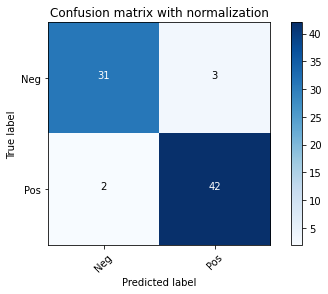

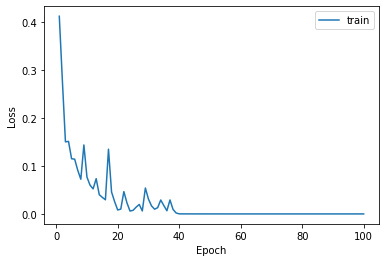

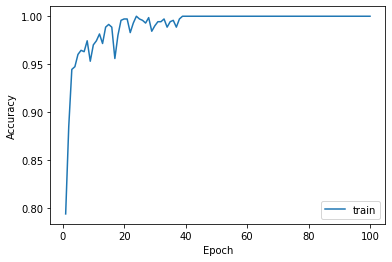



FOLD NUMBER 5
Let's now compile the model
TRAIN: 703 TEST: 78
Counter({1.0: 430, 0.0: 273}) is the train counts
Counter({1.0: 50, 0.0: 28}) is the test counts
78/78 [==============================] - 0s 340us/step
Test accuracy : 92.31


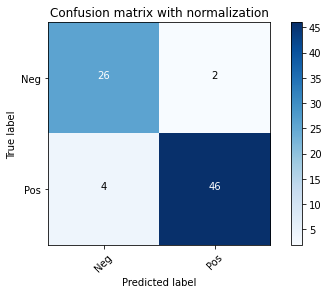

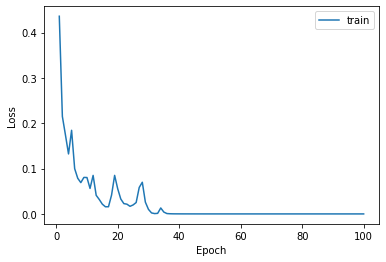

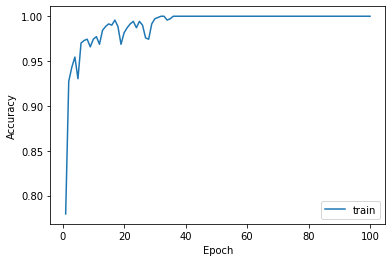



FOLD NUMBER 6
Let's now compile the model
TRAIN: 703 TEST: 78
Counter({1.0: 434, 0.0: 269}) is the train counts
Counter({1.0: 46, 0.0: 32}) is the test counts
78/78 [==============================] - 0s 308us/step
Test accuracy : 93.59


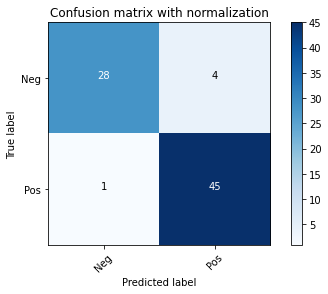

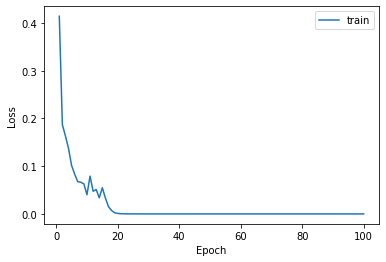

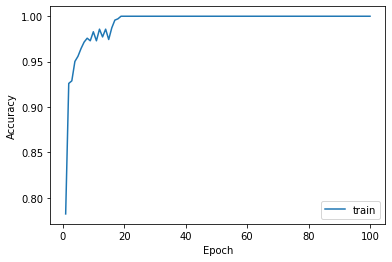



FOLD NUMBER 7
Let's now compile the model
TRAIN: 703 TEST: 78
Counter({1.0: 436, 0.0: 267}) is the train counts
Counter({1.0: 44, 0.0: 34}) is the test counts
78/78 [==============================] - 0s 313us/step
Test accuracy : 88.46


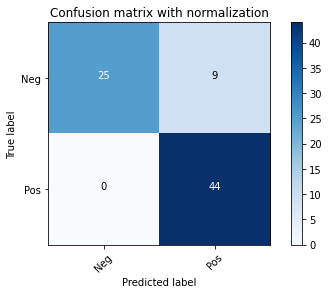

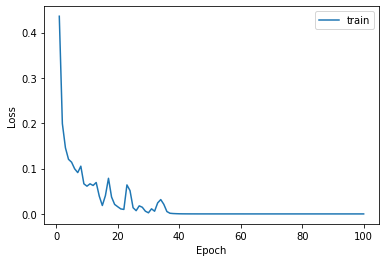

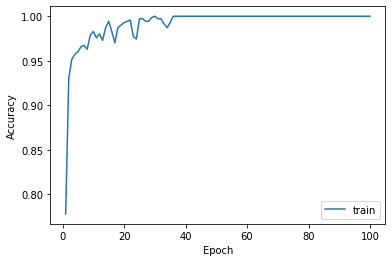



FOLD NUMBER 8
Let's now compile the model
TRAIN: 703 TEST: 78
Counter({1.0: 436, 0.0: 267}) is the train counts
Counter({1.0: 44, 0.0: 34}) is the test counts
78/78 [==============================] - 0s 336us/step
Test accuracy : 93.59


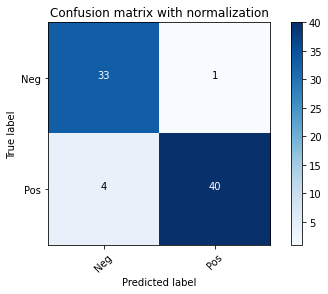

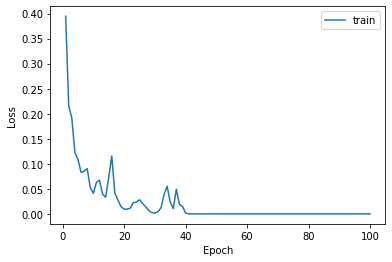

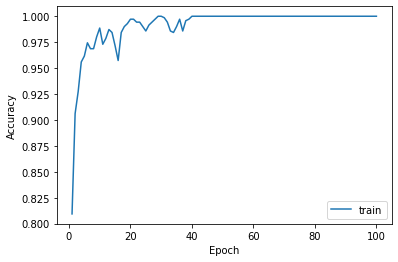



FOLD NUMBER 9
Let's now compile the model
TRAIN: 703 TEST: 78
Counter({1.0: 429, 0.0: 274}) is the train counts
Counter({1.0: 51, 0.0: 27}) is the test counts
78/78 [==============================] - 0s 340us/step
Test accuracy : 89.74


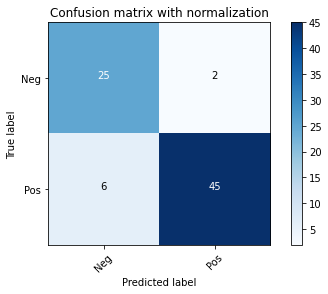

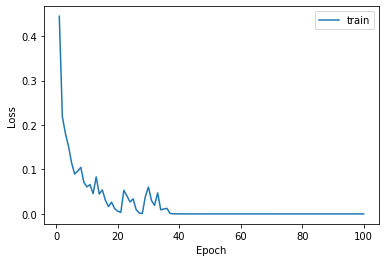

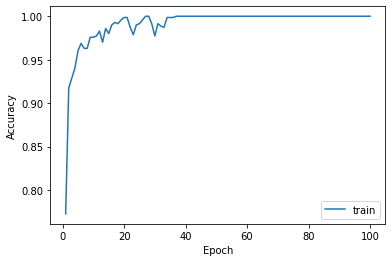



FOLD NUMBER 10
Let's now compile the model
TRAIN: 703 TEST: 78
Counter({1.0: 426, 0.0: 277}) is the train counts
Counter({1.0: 54, 0.0: 24}) is the test counts
78/78 [==============================] - 0s 294us/step
Test accuracy : 92.31


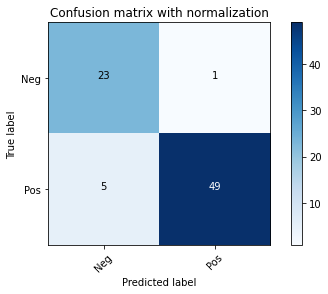

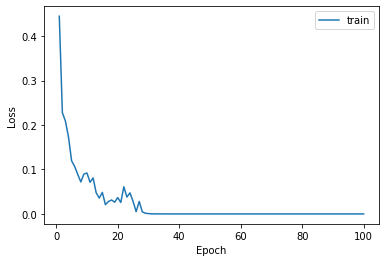

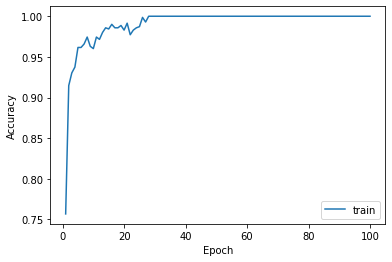



2th is the best model
Saved model to disk


92.57059335708618

In [0]:
KF(X_norm,y_norm.reshape((-1,1)),epochs=100,num_splits=10,batch_size=20,normalized=True)  #with all normalization

FOLD NUMBER 1
Let's now compile the model
TRAIN: 702 TEST: 79
Counter({1.0: 430, 0.0: 272}) is the train counts
Counter({1.0: 50, 0.0: 29}) is the test counts
79/79 [==============================] - 1s 16ms/step
Test accuracy : 63.29


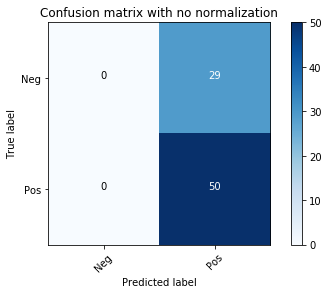

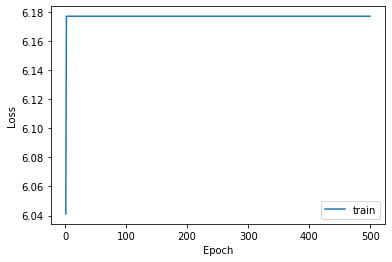

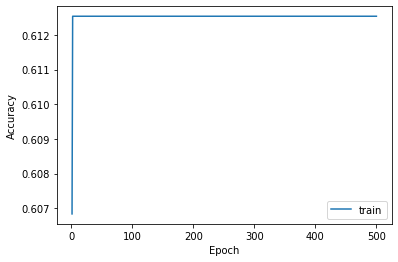



FOLD NUMBER 2
Let's now compile the model
TRAIN: 703 TEST: 78
Counter({1.0: 431, 0.0: 272}) is the train counts
Counter({1.0: 49, 0.0: 29}) is the test counts
78/78 [==============================] - 1s 17ms/step
Test accuracy : 92.31


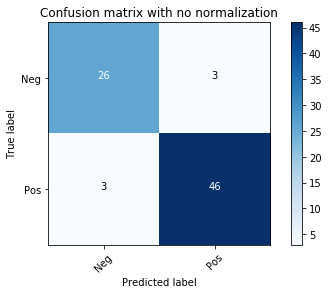

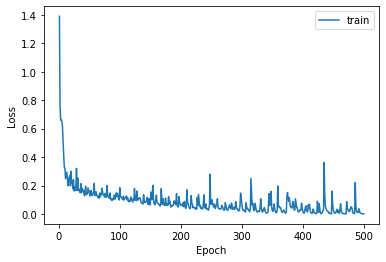

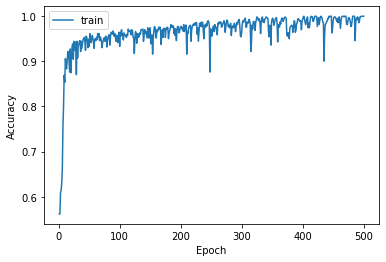



FOLD NUMBER 3
Let's now compile the model
TRAIN: 703 TEST: 78
Counter({1.0: 432, 0.0: 271}) is the train counts
Counter({1.0: 48, 0.0: 30}) is the test counts
78/78 [==============================] - 1s 17ms/step
Test accuracy : 38.46


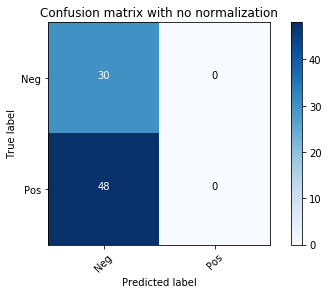

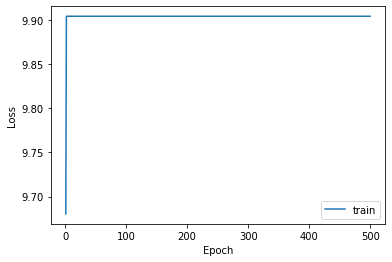

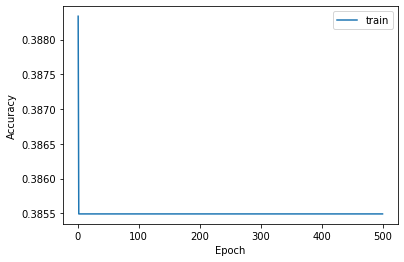



FOLD NUMBER 4
Let's now compile the model
TRAIN: 703 TEST: 78
Counter({1.0: 432, 0.0: 271}) is the train counts
Counter({1.0: 48, 0.0: 30}) is the test counts
78/78 [==============================] - 1s 18ms/step
Test accuracy : 92.31


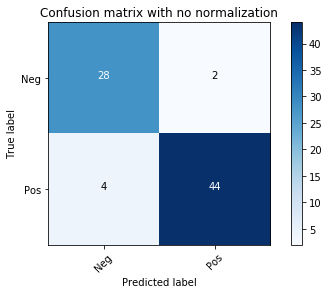

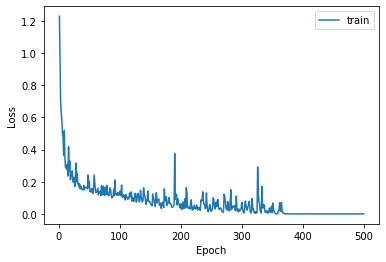

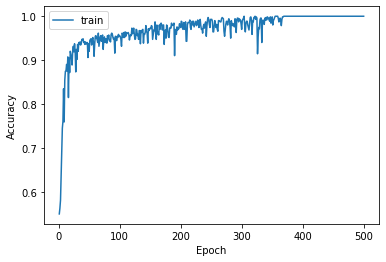



FOLD NUMBER 5
Let's now compile the model
TRAIN: 703 TEST: 78
Counter({1.0: 441, 0.0: 262}) is the train counts
Counter({0.0: 39, 1.0: 39}) is the test counts
78/78 [==============================] - 1s 18ms/step
Test accuracy : 50.00


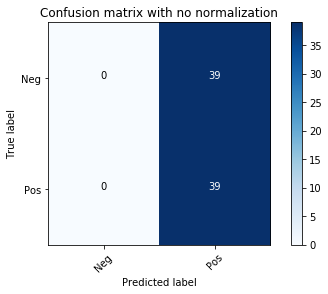

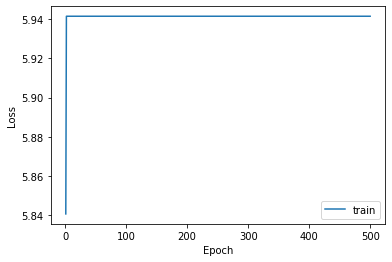

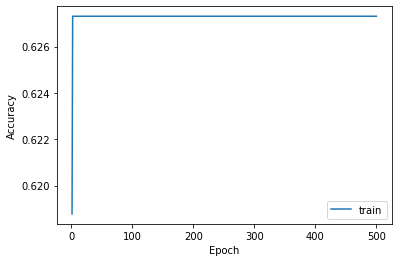



FOLD NUMBER 6
Let's now compile the model
TRAIN: 703 TEST: 78
Counter({1.0: 430, 0.0: 273}) is the train counts
Counter({1.0: 50, 0.0: 28}) is the test counts
78/78 [==============================] - 2s 19ms/step
Test accuracy : 35.90


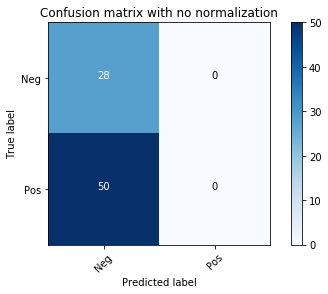

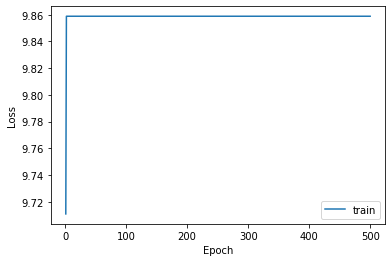

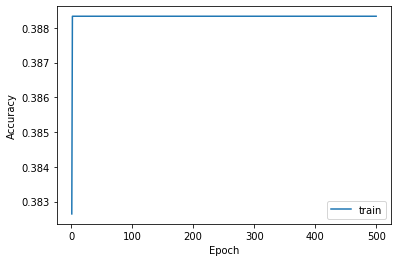



FOLD NUMBER 7
Let's now compile the model
TRAIN: 703 TEST: 78
Counter({1.0: 432, 0.0: 271}) is the train counts
Counter({1.0: 48, 0.0: 30}) is the test counts
78/78 [==============================] - 2s 19ms/step
Test accuracy : 61.54


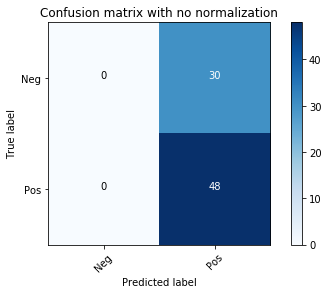

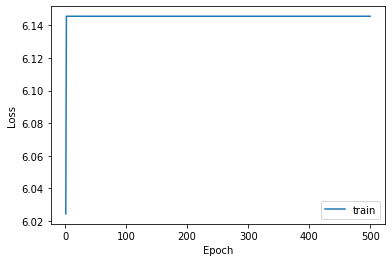

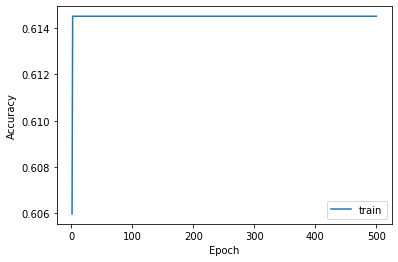



FOLD NUMBER 8
Let's now compile the model
TRAIN: 703 TEST: 78
Counter({1.0: 425, 0.0: 278}) is the train counts
Counter({1.0: 55, 0.0: 23}) is the test counts
78/78 [==============================] - 2s 20ms/step
Test accuracy : 70.51


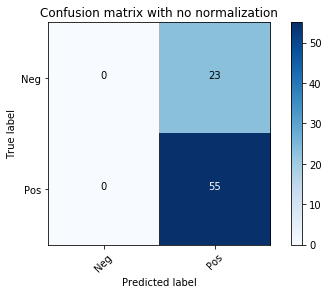

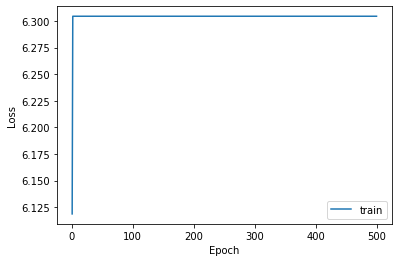

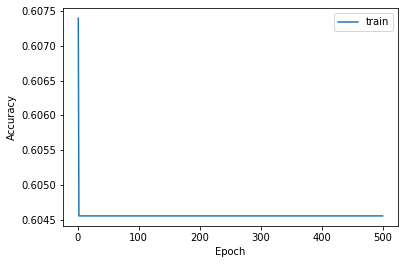



FOLD NUMBER 9
Let's now compile the model
TRAIN: 703 TEST: 78
Counter({1.0: 440, 0.0: 263}) is the train counts
Counter({1.0: 40, 0.0: 38}) is the test counts
78/78 [==============================] - 2s 21ms/step
Test accuracy : 91.03


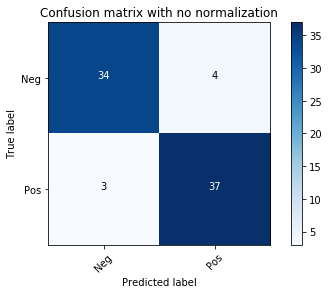

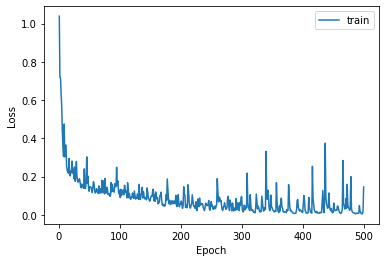

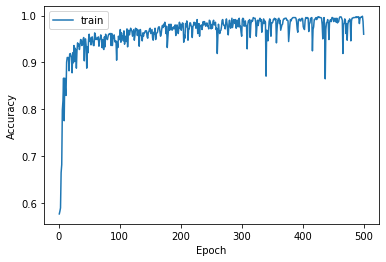



FOLD NUMBER 10
Let's now compile the model
TRAIN: 703 TEST: 78
Counter({1.0: 427, 0.0: 276}) is the train counts
Counter({1.0: 53, 0.0: 25}) is the test counts
78/78 [==============================] - 2s 20ms/step
Test accuracy : 67.95


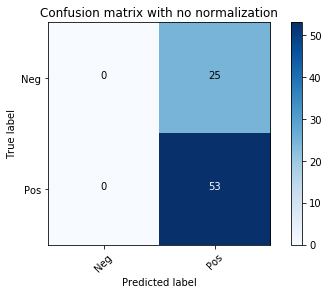

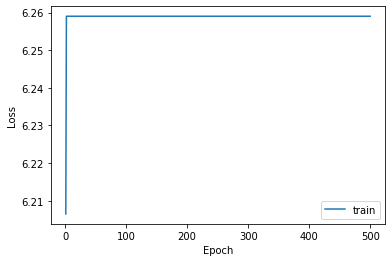

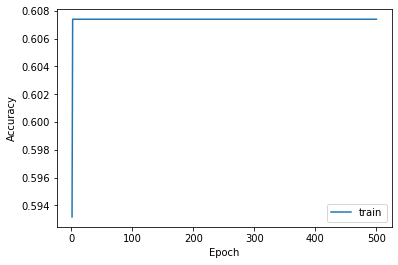

66.32911398460323

In [0]:
KF(X_no_norm,y_no_norm.reshape((-1,1)),epochs=500,num_splits=10,batch_size=20)  #with no normalization